In [ ]:
#@title Copyright 2020 The Earth Engine Community Authors { display-mode: "form" }
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Detecting Changes in Sentinel-1 Imagery (Part 3)

Author: mortcanty




### Run me first

Run the following cell to initialize the API. The output will contain instructions on how to grant this notebook access to Earth Engine using your account.

In [1]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=RQ6pJ-VjpqzTz2TDjzZLq_k-EdgyPQpgn8_OhjuxIYI&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/4wFEaRpKZp-kNRLWtfCi00-p2v0GQU-cUpWFsDWqcGHd7S67HCcvjjA

Successfully saved authorization token.


### Datasets and Python modules
One [dataset](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD) will be used in the tutorial:
- COPERNICUS/S1_GRD_FLOAT
  - Sentinel-1 ground range detected images

The following cell imports some python modules which we will be using as we go along and enables inline graphics.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, gamma, f, chi2
import IPython.display as disp
import time
%matplotlib inline

This cell carries over the chi square cumulative distribution function and the determinant of a Sentinel-1 image from Part 2.

In [3]:
def chi2cdf(chi2,df):
    ''' Chi square cumulative distribution function for df degrees of freedom 
        using the built-in incomplete gamma function gammainc() '''
    return ee.Image(chi2.divide(2)).gammainc(ee.Number(df).divide(2))

def det(im):
    ''' Determinant of 2x2 diagonal covariance matrix '''
    return im.expression('b(0)*b(1)')    

And to make use of interactive graphics, we import the _folium_ package:

In [4]:
# Import the Folium library.
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

## Part 3. Multitemporal change detection


Continuing from Part 2, in which we discussed bitemporal change detection with Sentinel 1 images, we turn our attention to the multitemporal case. To get started, we obviously need ...
 
### A time series
 
Here is a fairly interesting one: a region in South Yorkshire, England where, in November 2019, extensive flooding occurred along the River Don just north of the city of Doncaster.

In [5]:
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -1.2998199462890625,
              53.48028242228504
            ],
            [
              -0.841827392578125,
              53.48028242228504
            ],
            [
              -0.841827392578125,
              53.6958933974518
            ],
            [
              -1.2998199462890625,
              53.6958933974518
            ],
            [
              -1.2998199462890625,
              53.48028242228504
            ]
          ]
        ]
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi = ee.Geometry.Polygon(coords)

The image collection below covers the months of September, 2019 through January, 2020 at 6-day intervals:

In [6]:
im_coll = ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT') \
                .filterBounds(aoi) \
                .filterDate(ee.Date('2019-09-01'),ee.Date('2020-01-31')) \
                .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')) \
                .filter(ee.Filter.eq('relativeOrbitNumber_start', 132)) \
                .sort('system:time_start')

acq_times = im_coll.aggregate_array('system:time_start').getInfo()
[time.strftime('%x',time.gmtime(acq_time/1000)) for acq_time in acq_times]

['09/06/19',
 '09/12/19',
 '09/18/19',
 '09/30/19',
 '10/06/19',
 '10/12/19',
 '10/18/19',
 '10/24/19',
 '10/30/19',
 '11/05/19',
 '11/11/19',
 '11/17/19',
 '11/23/19',
 '11/29/19',
 '12/05/19',
 '12/11/19',
 '12/17/19',
 '12/23/19',
 '12/29/19',
 '01/04/20',
 '01/10/20',
 '01/16/20',
 '01/22/20',
 '01/28/20']

(Actually there is one missing acquisition, namely for September 24, 2019.) 

It will turn out to be more convenient to work with a list rather than a collection, so we'll convert the collection to a list and, while  we're at it, clip the images to our AOI:

In [34]:
def clip_iter(current,prev):
    '''Iteration function to clip a list of images.'''
    prev = ee.Dictionary(prev)
    im_list = ee.List(prev.get('im_list'))
    aoi = prev.get('aoi') 
    im_list = im_list.add(ee.Image(current).clip(aoi))
    return ee.Dictionary({'im_list': im_list, 'aoi': aoi})

im_list = im_coll.toList(im_coll.size())    

# Clip the list of images.
first = ee.Dictionary({'im_list': ee.List([]), 'aoi': aoi}) 
im_list = ee.List(ee.Dictionary(im_list.iterate(clip_iter, first)).get('im_list'))  

im_list.length().getInfo()

24

Here is an rgb composite of the VV bands of the first three images, after conversion to decibels and clipping to the AOI. Note that some changes already show up in this representation as colored pixels.

In [37]:
def selectvv(current):
    return ee.Image(current).select('VV')

vv_list = im_list.map(selectvv)

location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(location=location, zoom_start=11, height=800, width=1000)
images = ee.Image.rgb(vv_list.get(0),vv_list.get(1),vv_list.get(2)).log10().multiply(10)
mp.add_ee_layer(images, {'min': -20,'max': 0}, 'First three images')
mp.add_child(folium.LayerControl())

display(mp)

Now we have a series of 24 SAR images and, for whatever reason, would like to know where and when changes have taken place. A first reaction might be: 
 
*What's the problem? Just apply the bitemporal method we developed in Part 2 to each of the 23 time intervals.*
 
Well, one problem is the rate of false positives. If the bitemporal tests are statistically independent, then the probability of **not** getting a false positive over a series of length $k$ is the product of not getting one in each of the $k-1$ intervals, i.e., $(1-\alpha)^{k-1}$ and the overall first kind error probabilty $\alpha_T$ is its complement:
 
$$
\alpha_T = 1-(1-\alpha)^{k-1}. \tag{3.1}
$$
 
For our case, even with a small value of $\alpha=0.01$, this gives a whopping 20.6% false positive rate:

In [ ]:
alpha = 0.01
1-(1-alpha)**23  

Actually things are a even worse. The bitemporal tests are manifestly not independent because all consecutive tests have one image in common. To illustrate, let's take random samples from the bitemporal LRT statistics (monovariate case) 
 
$$
{s_0\over s_1}, {s_1\over s_2}, \dots , {s_{k-1}\over s_k}
$$
 
and calculate their correlation matrix under $H_0$, i.e., for no-change pixels. 
 
First we define small polygon _aoi_sub_ over the Thorne Moors (in the northeast corner of the AOI) for which we hope there are few significant changes.

In [10]:
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -0.9080886840820311,
              53.65644026660197
            ],
            [
              -0.9225082397460938,
              53.625706323730334
            ],
            [
              -0.8861160278320312,
              53.61104384269007
            ],
            [
              -0.8655166625976562,
              53.640770789319845
            ],
            [
              -0.9080886840820311,
              53.65644026660197
            ]
          ]
        ]
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi_sub = ee.Geometry.Polygon(coords)

This is perhaps overkill to illustrate a simple point, but it introduces the important technique of iterating over an _ee:List()_ object, which will be used extensively later.

In [38]:
def list_iter(current,prev):
    '''The iteration algorithm for sampling the test statistics'''    
#  Get current index i from the list. 
    i = ee.Number(current)
#  Extract aoi, vv_list and list of samples from previous iteration.
    prev = ee.Dictionary(prev)
    aoi = prev.get('aoi')
    vv_list = ee.List(prev.get('vv_list'))
    samples = ee.List(prev.get('samples'))
#  Sample the ratio s_i/s_(i+1).    
    sample = ee.Image(vv_list.get(i)).divide(vv_list.get(i.add(1))) \
                 .clip(aoi) \
                 .sample(scale=10, numPixels=5000, seed=123) \
                 .aggregate_array('VV')
#  Return the prev dictionary, appending the current sample to the list of samples.                  
    return ee.Dictionary({'aoi': aoi, 'vv_list': vv_list, 'samples': samples.add(sample)})

# Initialize the iteration with an empty list and aoi_sub.
first = ee.Dictionary({'aoi': aoi_sub, 'vv_list': vv_list, 'samples': ee.List([])})
# iterate over the first 10 list indices to get the samples.
result = ee.List.sequence(0,9).iterate(list_iter,first)
samples = ee.List(ee.Dictionary(result).get('samples'))

We examine the the correlation matrix:

In [12]:
np.set_printoptions(precision=2, suppress=True)
print( np.corrcoef(samples.getInfo()) )

[[ 1.   -0.23 -0.01  0.01 -0.03  0.02  0.    0.    0.    0.  ]
 [-0.23  1.   -0.22 -0.02  0.02  0.06 -0.02  0.08  0.   -0.07]
 [-0.01 -0.22  1.   -0.28 -0.02  0.01  0.02 -0.03  0.01 -0.  ]
 [ 0.01 -0.02 -0.28  1.   -0.3   0.   -0.05  0.03  0.    0.01]
 [-0.03  0.02 -0.02 -0.3   1.   -0.31 -0.02  0.   -0.06  0.02]
 [ 0.02  0.06  0.01  0.   -0.31  1.   -0.3   0.01 -0.   -0.03]
 [ 0.   -0.02  0.02 -0.05 -0.02 -0.3   1.   -0.35  0.06 -0.  ]
 [ 0.    0.08 -0.03  0.03  0.    0.01 -0.35  1.   -0.29 -0.02]
 [ 0.    0.    0.01  0.   -0.06 -0.    0.06 -0.29  1.   -0.33]
 [ 0.   -0.07 -0.    0.01  0.02 -0.03 -0.   -0.02 -0.33  1.  ]]


and see from the above-diagonal matrix elements that the consecutive tests are (at least weakly) correlated. 
 
The best one can say then is 
 
$$
\alpha_T \le (k-1)\alpha, \tag{3.2}
$$
 
or 23% for $k=24$ and $\alpha=0.01$ . If we wish to set a false positive rate of, say, 1% for the entire series, then each bitemporal test must have a significance level of $\alpha=0.0004$ and a correspondingly large false negative rate $\beta$. In other words  many significant changes may be missed.


How to proceed? Perhaps by being a bit less ambitious at first and asking the simpler question: _Were there any changes at all over the interval?_ If the answer is affirmative, we can worry about how many there were and when they occurred later. 
 
Let's formulate this question as  a so-called _omnibus test_ (link).

### An omnibus test for change
 
As before, we'll start with the easier monovariate case. For the series of _VV_ intensity images acquired at times $t_1, t_2,\dots t_k$, our null hypothesis is that, at a given pixel position,  there has been no change in the signal strengths $a_i=\langle|S^{a_i}_{vv}|^2\rangle$ over the entire period
 
$$
H_0:\quad a_1 = a_2 = \dots = a_k = a.
$$
 
The alternative hypothesis is that there was at least one change (and possibly many) over the interval. For the mathematically inclined this can be witten succinctly as
 
$$
H_1:\quad \exists\ i,j :\ a_i \ne a_j,
$$
 
which says _there exist indices $i, j$ for which $a_i$ is not equal to_ $a_j$.
 
Again, the likelihood functions are products of gamma distributions:
 
$$
L_1(a_1,\dots,a_k) =\prod_{i=1}^k p(s_i\mid a_i) = {1\over\Gamma(m)^k}\left[\prod_i{a_i\over m}\right]^{-m}\left[\prod_i s_i\right]^{m-1}\exp(-m\sum_i{s_i\over a_i}) \tag{3.3}
$$
 
$$
L_0(a)  = \prod_{i=1}^k p(s_i\mid a) = {1\over\Gamma(m)^k} \left[{a\over m}\right]^{-mk}\left[\prod_i s_i\right]^{m-1}\exp(-{m\over a}\sum_i s_i) \tag{3.4}
$$
 
and $L_1$ is maximized for $\hat a_i = s_i,\ i=1\dots k,$ while $L_0$ is maximized for $\hat a = {1\over k}\sum_i s_i$. So with a bit of simple algebra our likelihood ratio test statistic is
 
$$
Q_k = {L_1(\hat a_1,\dots,\hat a_k)\over L_0(\hat a)} = \left[k^k{\prod_i s_i\over (\sum_i s_i)^k}\right]^m \tag{3.5}
$$
 
and is called an _omnibus test statistic_. Note that, for $k=2$, we get the bitemporal LRT given by Eq. (2.10).
 
We can't expect to find an analytical expression for the probability distribution of this LRT statistic, so we will again invoke Wilks' Theorem and work with
 
$$
-2 \log{Q_k} = \big[k\log{k}+\sum_i\log{s_i}-k\log{\sum_i s_i}\big](-2m) \tag{3.6}
$$
 
According to Wilks, it should be approximately chi square distributed with $k-1$ degrees of freedom under $H_0$. (Why?)

The input cell below evaluates the test statistic for a list of images. 

In [39]:
def omnibus(im_list, m=5):
    '''omnibus test statistic, monovariate case'''
    def log(current):
        return ee.Image(current).log()

    im_list = ee.List(im_list)
    k = im_list.length() 
    klogk = k.multiply(k.log())
    klogk = ee.Image.constant(klogk)
    sumlogs = ee.ImageCollection(im_list.map(log)).reduce(ee.Reducer.sum())
    logsum = ee.ImageCollection(im_list).reduce(ee.Reducer.sum()).log()
    return klogk.add(sumlogs).subtract(logsum.multiply(k)).multiply(-2*m)

And here is the comparison for pixels in _aoi_sub_ with the chi square distribution with $k-1$ degrees of freedom. We choose $k=5$ because we expect fewer changes in September/October than over the complete sequence $k=24$, which extends into January. 

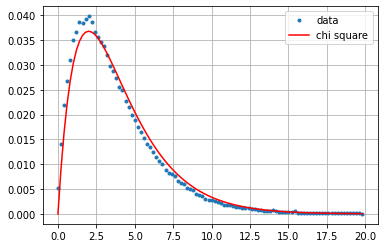

In [40]:
k=5
hist = omnibus(vv_list.slice(0,k)) \
         .reduceRegion(ee.Reducer.fixedHistogram(0, 20, 100),geometry=aoi_sub,scale=10) \
         .get('constant') \
         .getInfo()
 
a = np.array(hist)
x = a[:,0]
y = a[:,1]/np.sum(a[:,1])
plt.plot(x, y, '.', label='data')
plt.plot(x, chi2.pdf(x, k-1)/5, '-r', label='chi square')
plt.legend()
plt.grid()
plt.show()

It appears that Wilks' Theorem is again a fairly good approximation. So why not generate a change map for the full series? The good news is that we now have the overall false positive probability $\alpha$ under control. Here we set it to $\alpha=0.01$.

In [41]:
# The change map for alpha = 0.01.
k = 24
p_value = ee.Image.constant(1).subtract(chi2cdf(omnibus(vv_list),k-1))
c_map = p_value.multiply(0).where(p_value.lt(0.01),1)
c_map = c_map.updateMask(c_map.gt(0))    
# Overlay onto map.
location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(location=location, zoom_start=11, height=800, width=1000)
mp.add_ee_layer(c_map, {'min': 0,'max': 1, 'palette': ['black','red']}, 'change map')
mp.add_child(folium.LayerControl())

So plenty of changes, but hard to interpret considering the time span. Although we can see _where_ changes took place, we know neither _when_ they occurred nor their _multiplicity_. Also there is a matter that we have glossed over up until now, and that is ...
 
### A question of scale
 
The number of looks plays an important role in all of the formulae that we have discussed so far, and for the Sentinel-1 ground range detected imagery we have used $m=5$ throughout. (Later we'll actually prefer to use the equivalent number of looks ENL that we introduced at the end of Part 1.) When we display a change map interactively, the zoom factor determines the image pyramid level at which the servers perform the required calculations and pass the result to the client. If the calculations are not at the nominal scale of 10m then the number of looks is effectively larger than 5 due to the averaging involved in constructing higher pyramid levels. The effect can be seen in the folium map in the output cell above: the number of change pixels seems to decrease when we zoom out. There is no problem when we export our results to GEE assets, to Google Drive or to Cloud storage, since we can simply choose the nominal scale for export. 
 
In order to see the changes correctly at all zoom levels, we can force GEE to work at the nominal scale by reprojecting before displaying on the map:

In [42]:
c_map_10m = c_map.reproject(c_map.projection().crs(), scale=10)
mp = folium.Map(location=location, zoom_start=11, height=800, width=1000)
mp.add_ee_layer(c_map, {'min': 0,'max': 1, 'palette': ['black','red']}, 'Change map')
mp.add_ee_layer(c_map_10m, {'min': 0,'max': 1, 'palette': ['black','blue']}, 'Change map (10m)')

mp.add_child(folium.LayerControl())

You will notice in the output cell above that the calculation at nominal scale (the blue pixels) now takes considerably longer to complete. Also some red pixels are not covered by blue ones. Those changes are a spurious result of the falsified number of looks. Nevertheless for quick previewing purposes we might prefer to do without the reprojection. 

### A sequential omnibus test
Recalling the last remark at the end of Part 2, let's now guess the omnibus LRT for the bivariate or dual pol case. From Eq. (3.5), replacing $s_i$ with $|c_i|$ and $k^k$ with $k^{2k}$, we get 
 
$$
Q_k =  \left[k^{2k}{\prod_i |c_i|\over |\sum_i c_i|^k}\right]^m. \tag{3.7}
$$
 
Which brings us to the heart of this Tutorial. We will now decompose Eq. (3.7) into a product of independent likelihood ratio tests which will enable us to determine when changes occurred at each pixel location. Then we'll code a complete multitemporal change detection algorithm on the GEE Python API.

 
#### Single polarization
 
 
 
Rather than make a formal derivation, we will illustrate the decomposition on a series of $k=5$ single polarization (VV) measurements. The omnibus test Eq. (3.5) for any change over the series from $t_1$ to $t_5$ is
 
$$
Q_5 = \left[ 5^5 {s_1s_2s_3s_4s_5\over (s_1+s_2+s_3+s_4+s_5)^5}\right]^m.
$$
 
If we accept the null hypothesis $a_1=a_2=a_3=a_4=a_5$ we're done and can move on to the next pixel (figuratively of course, since this stuff is all done in parallel). But suppose we have rejected the null hypothesis, i.e., there was a least one significant change. In order to find it (or them), we begin by testing the first of the four intervals. That's just the bitemporal test from Part 2, but let's call it $R_2$ rather than $Q_2$,
 
$$
R_2 = \left[ 2^2 {s_1s_2\over (s_1+s_2)^2}\right]^m.
$$
 
Now suppose we conclude no change, that is, $a_1=a_2$. Now we don't do just another bitemporal test on the second interval. Instead we test the hypothesis
 
\begin{align*}
H_0:\ a_1=a_2= a_3\ (=a)\cr
{\rm against}\quad H_1:\ a_1=a_2\ (=a) \ne a_3.
\end{align*}
 
So the alternative hypothesis is _there was no change in the first interval and there was a change in the second interval_. The LRT is easy to derive, but let's go through it anyway.
 
\begin{align*}
        {\rm From\ Eq.}\ (3.4):\  &L_0(a)  = {1\over\Gamma(m)^3} \left[{a\over m}\right]^{-3m}\left[s_1s_2s_3\right]^{m-1}\exp(-{m\over a}(s_1+s_2+s_3)  \cr
        &\hat a = {1\over 3}(s_1+s_2+s_3) \cr
=>\           &L_0(\hat a) = {1\over\Gamma(m)^3} \left[{s_1+s_2+s_3\over 3m}\right]^{-3m}\left[s_1s_2s_3\right]^{m-1} \exp(-3m) \cr
{\rm From\ Eq.}\ (3.3):\ &L_1(a_1,a_2,a_3) = {1\over\Gamma(m)^3}\left[a_1a_2a_3\over m\right]^{-m}[s_1s_2s_3]^{m-1}\exp(-m(s_1/a_1+s_2/a_2+s_3/a_3)\cr
&\hat a_1 = \hat a_2 = {1\over 2}(s_1+s_2),\quad \hat a_3 = s_3 \cr
=>\ &L_1(\hat a_1,\hat a_2, \hat a_3) = {1\over\Gamma(m)^3}\left[(s_1+s_2)^2s_3\over 2^2m \right]^{-m}[s_1s_2s_3]^{m-1}\exp(-3m)
\end{align*}
 
And, taking the ratio $L_0/L_1$of the maximum likelihoods,
 
$$
R_3 = \left[{3^3\over 2^2}{(s_1+s_2)^2s_3\over (s_1+s_2+s_3)^3}\right]^m.
$$
 
Not too hard to guess that, if we accept $H_0$ again, we go on to test

\begin{align*}
H_0:\ a_1=a_2=a_3=a_4\ (=a)\cr
{\rm against}\quad H_1:\ a_1=a_2=a_3\ (=a) \ne a_4.
\end{align*}

with LRT statistic
 
$$
R_4 = \left[{4^4\over 3^3}{(s_1+s_2+s_3)^3s_4\over (s_1+s_2+s_3+s_4)^4}\right]^m,
$$
 
and so on to $R_5$ and the end of the time series. Now for the cool part (try it out yourself):
 
$$
R_2\times R_3\times R_4 \times R_5 = Q_5.
$$


So, generalizing to a series of length $k$: 

**The omnibus test statistic $Q_k$ may be factored into the product of  LRT's $R_j$ which test for homogeneity in the measured reflectance signal up to and including time $t_j$, assuming homegeneity up to time $t_{j-1}$:**

$$
Q_k = \prod_{j=2}^k R_j, \quad R_j = \left[{j^j\over (j-1)^{j-1}}{(s_1+\dots +s_{j-1})^{j-1}s_j\over (s_1+\dots +s_j)^j}\right]^m,\quad j = 2\dots k.  \tag{3.8}
$$

Moreover the test statistics $R_j$ are independent under $H_0$. 
This can be shown analytically, see [Conradsen et al. (2016)](https://ieeexplore.ieee.org/document/7398022), but we'll show it here empirically. 
We repeat the sampling procedure that we carried out previously for the simple bitemporal tests $s_i/s_{i+1}$ and the no-change region _aoi_sub_, but now for the test statistics $R_j$.


In [43]:
def list_iter(current,prev):
    '''The iteration algorithm for sampling the test statistics'''    
#  Get current index i from the list. 
    j = ee.Number(current)
#  Extract aoi, vv_list and list of samples from previous iteration.
    prev = ee.Dictionary(prev)
    aoi = prev.get('aoi')
    vv_list = ee.List(prev.get('vv_list'))
    samples = ee.List(prev.get('samples'))
#  Get the factors in the expression for Rj.    
    sj = vv_list.get(j.subtract(1))
    jfact = j.pow(j).divide(j.subtract(1).pow(j.subtract(1)))
    sumj = ee.ImageCollection(vv_list.slice(0,j)).reduce(ee.Reducer.sum())
    sumjm1 = ee.ImageCollection(vv_list.slice(0,j.subtract(1))).reduce(ee.Reducer.sum())
#  Put them together.     
    Rj = sumjm1.pow(j.subtract(1)).multiply(sj).multiply(jfact).divide(sumj.pow(j)).pow(5)    
#  Sample Rj.    
    sample = Rj.clip(aoi) \
               .sample(scale=10, numPixels=5000, seed=123) \
               .aggregate_array('VV_sum')
#  Return the prev dictionary, appending the current sample to the list of samples.                  
    return ee.Dictionary({'aoi': aoi, 'vv_list': vv_list, 'samples': samples.add(sample)})

# Initialize the iteration with an empty list of samples and aoi_sub.
first = ee.Dictionary({'aoi': aoi_sub, 'vv_list': vv_list, 'samples': ee.List([])})
# Iterate over the first 10 list indices.
result = ee.List.sequence(2,10).iterate(list_iter,first)
# Extract the samples list.
samples = ee.List(ee.Dictionary(result).get('samples'))
# Calculate and display the correlation matrix.
np.set_printoptions(precision=2, suppress=True)
print( np.corrcoef(samples.getInfo()) )

[[ 1.    0.01 -0.    0.01 -0.    0.04 -0.02 -0.01 -0.01]
 [ 0.01  1.    0.02  0.02  0.03  0.05  0.03  0.05  0.05]
 [-0.    0.02  1.    0.02  0.01  0.01  0.01  0.02  0.01]
 [ 0.01  0.02  0.02  1.    0.04  0.05  0.01  0.02  0.02]
 [-0.    0.03  0.01  0.04  1.    0.02  0.01  0.01  0.01]
 [ 0.04  0.05  0.01  0.05  0.02  1.   -0.01  0.06  0.02]
 [-0.02  0.03  0.01  0.01  0.01 -0.01  1.    0.02  0.01]
 [-0.01  0.05  0.02  0.02  0.01  0.06  0.02  1.    0.03]
 [-0.01  0.05  0.01  0.02  0.01  0.02  0.01  0.03  1.  ]]


The off-diagonal elements (almost) vanish. The not-so-small values can be attributed to the presence of some change pixels in the samples.

#### Dual polarization and an algorithm

With our substitution trick, we can now write down the sequential test for   dual polarization image time series. From Eq. (3.8) we get

$$
Q_k = \prod_{j=2}^k R_j , \quad R_j = \left[{j^{2j}\over (j-1)^{2(j-1)}}{|c_1+\dots +c_{j-1}|^{j-1}|c_j|\over |c_1+\dots +c_j|^j}\right]^m,\quad j = 2\dots k. \tag{3.9}
$$

And of course we have again to use Wilks' Theorem to get the _P_ values, so we work with

$$
-2\log{R_j} = -2m\Big[2(j\log{j}-(j-1)\log(j-1)+(j-1)\log\Big|\sum_{i=1}^{j-1}c_i \Big|+\log|c_j|-j\log\Big|\sum_{i=1}^j c_i\Big|\ \Big] \tag{3.10a}
$$

and

$$
-2\log Q_k = \sum_{j=2}^k -2\log R_j. \tag{3.10b}
$$

The statistic $-2\log R_j$ is approximately chi square distributed with two degrees of freedom. Similarly $-2\log Q_\ell$ is approximately chi square distributed with $2(k-1)$ degrees of freedom. Readers should satisfy themselves that these are indeed the degrees of freedom, taking into account that each measurement $c_i$ has two free parameters $|S^a_{vv}|^2$ and $|S^b_{vh}|^2$, see Eq. (2.13).

Now for the algorithm:

**The sequential omnibus change detection algorithm**

With a time series of $k$ SAR images $s=(c_1,c_2,\dots,c_k)$,

1.   Set $\ell = k$.
2.   Set $s = (c_{k-\ell+1}, \dots c_k)$.
3.   Perform the omnibus test $Q_\ell$ for any changes change over $s$.
4.   If no significant changes are found, stop.
5.   Successively test series $s$ with $R_2, R_3, \dots$ until the first significant change is met for $R_j$.
6.   Set $\ell = k-j+1$ and go to 2.  

Thus if a change is found, the series is truncated up to the point of change and the testing procedure is repeated for the rest of the series. Take for example a series of $k=5$ images. Suppose there is one change in the second interval only. Then the test sequence is (the asterisk means $H_0$ is rejected)

$$
Q^*_5 \to R_2 \to R^*_3 \to Q_3.
$$

If there are changes in the second and last intervals,

$$
Q^*_5 \to R_2 \to R^*_3 \to Q^*_3 \to R^*_3,
$$

and if there are significant changes in all four intervals,

$$
Q^*_5 \to R^*_2 \to Q^*_4 \to R^*_2 \to Q^*_3 \to R^*_2 \to Q^*_2.
$$

The approach taken in the coding of this algorithm is to pre-calculate  _P_ values for all of the $Q_\ell / R_j$ tests and then, in a second pass, to filter them to determine to points of change.



#### Pre-calculating the _P_ value array

|Table 3.1 |       |       |       |       |       |        |
|----------|-------|-------|-------|-------|-------|--------|
|  $\ell$  | $c_1$ | $c_2$ | $c_3$ | $c_4$ | $c_5$ |        |
| 5        |       | $R_2$ | $R_3$ | $R_4$ | $R_5$ | $Q_5$  |
| 4        |       |       | $R_2$ | $R_3$ | $R_4$ | $Q_4$  |
| 3        |       |       |       | $R_2$ | $R_3$ | $Q_3$  |
| 2        |       |       |       |       | $R_2$ | $Q_2$  | 

The following code cell performs a double iteration on the indices $\ell$ and $j$, returning an array of _P_ values for all possible LRT statistics. For example again for $k=5$, the code calculates the _P_ values for each $R_j$ entry in Table 3.1 as a list of lists.

Before calculating each row, the time series $c_1, c_2,c_3,c_4, c_5$ is sliced from $k-\ell+1$ to $k$. The last entry in each row is simply the product of the other entries,  $Q_\ell =\prod_{j=2}^\ell R_j.$

The program actually works with the logarithms of the test statistics, Equations (3.10).


In [27]:
def log_det_sum(im_list, j):
    '''Return log of determinant of the sum of the first j images in im_list.'''
    im_ist = ee.List(im_list)
    sumj = ee.ImageCollection(im_list.slice(0,j)).reduce(ee.Reducer.sum())                
    return ee.Image(det(sumj)).log()  

def log_det(im_list, j):
    '''Return log of the determinant of the jth image in im_list.'''
    im = ee.Image(ee.List(im_list).get(j.subtract(1)))
    return ee.Image(det(im)).log()      

def pval(im_list, j, median, m = 5):
    '''Calculate -2logRj for im_list and return P value and -2logRj.'''
    im_list = ee.List(im_list)
    j = ee.Number(j)
    m2logRj = log_det_sum(im_list,j.subtract(1)) \
             .multiply(j.subtract(1)) \
             .add(log_det(im_list,j))  \
             .add(ee.Number(2).multiply(j).multiply(j.log())) \
             .subtract(ee.Number(2).multiply(j.subtract(1)) \
             .multiply(j.subtract(1).log())) \
             .subtract(log_det_sum(im_list,j).multiply(j)) \
             .multiply(-2).multiply(m)
    pv = ee.Image.constant(1).subtract(chi2cdf(m2logRj, 2))
    return (ee.Algorithms.If(median, pv.focal_median(), pv), m2logRj)             

def js_iter(current, prev):
    '''Iteration function for j=2,3,...,l.'''
    j = ee.Number(current) 
    prev = ee.Dictionary(prev)   
    im_list = prev.get('im_list')
    median = prev.get('median')
    pvs = ee.List(prev.get('pvs'))
    m2logQl = ee.Image(prev.get('m2logQl'))
#  Get P value and -2logQj.     
    pv, m2logRj = pval(im_list, j, median)
#  Append to P value list  
    pvs = pvs.add(pv)       
#  Update -2logQl = sum of -2logQj    
    m2logQl = m2logQl.add(m2logRj)
    return ee.Dictionary({'im_list': im_list, 'median': median, 'pvs': pvs, 'm2logQl': m2logQl})

def ells_iter(current, prev):
    '''Iteration function for ell = k,k-1,...,2'''
    ell = ee.Number(current)    
    prev = ee.Dictionary(prev)
    k = ee.Number(prev.get('k'))
    median = prev.get('median')
    im_list = ee.List(prev.get('im_list'))
    pv_arr = ee.List(prev.get('pv_arr'))
#  Slice the series from k-l+1 to k (image indices start from 0).
    im_list_ell = im_list.slice(k.subtract(ell),k)
#  Iterate over the sliced series for j = 2 to k-l+1.   
    js = ee.List.sequence(2,ell)
    first = ee.Dictionary({'im_list': im_list_ell, 'median': median, 'pvs': ee.List([]), 
                           'm2logQl': ee.Image.constant(0)})
    result = ee.Dictionary(js.iterate(js_iter, first))
#  Get the P values for m2logRj and m2logQl and append to P value array.  
    pvs = ee.List(result.get('pvs'))
    m2logQl = ee.Image(result.get('m2logQl'))
    pvQl = ee.Image.constant(1).subtract(chi2cdf(m2logQl, ell.subtract(1).multiply(2)))
    pvs = pvs.add(pvQl)
    return ee.Dictionary({'k': k, 'median': median, 'im_list': im_list, 'pv_arr': pv_arr.add(pvs)})

def p_values(im_list, median = False):
    '''pre-calculate the P-value array'''       
    im_list = ee.List(im_list)
    k = im_list.length() 
#  Iterate over l = k to 2.
    ells = ee.List.sequence(k,2,-1)    
    first = ee.Dictionary({'k': k, 'median': median, 'im_list': im_list, 'pv_arr': ee.List([])})
    result = ee.Dictionary(ells.iterate(ells_iter,first))
#  Return the P value array ell = k,...,2, j = 2,...,l.
    return result.get('pv_arr')

#### Filtering the _P_ values

|Table 3.2 |       |       |       |       |       |        |
|----------|-------|-------|-------|-------|-------|--------|
|$i\ $ / $j$|      |     1 |     2 |     3 |     4 |        |
| 1        |       | $P_2$ | $P_3$ | $P_4$ | $P_5$ | $P_{Q5}$  |
| 2        |       |       | $P_2$ | $P_3$ | $P_4$ | $P_{Q4}$  |
| 3        |       |       |       | $P_2$ | $P_3$ | $P_{Q3}$  |
| 4        |       |       |       |       | $P_2$ | $P_{Q2}$  | 

The pre-calculated _P_ values in _pv_arr_ (shown schematically in Table 3.2 for $k=5$) are then scanned in nested iterations over indices $i$ and $j$ to determine the following thematic change maps:
- cmap: the interval of the most recent change (one band, byte values $0, \dots, k-1$),
- smap: the interval of the first change (one band, byte values $0,\dots, k-1$ ),
- fmap: the number of changes (one band, byte values $0,\dots, k-1$),
- bmap: the changes in each interval ($k-1$ bands, byte values $0,1$).

A boolean variable _median_ is included in the code. Its purpose is to reduce the salt-and-pepper effect in no-change regions, which is a consequence of the uniform distribution of the _P_ values under $H_0$ (see the section "A note on _P_ values" in Part 2). If _median_ is _True_, the _P_ values for each $Q_\ell$ statistic are passed through a $3\times 3$ median filter before being compared with the significance threshold. This is not statistically kosher but probably justifiable if one is only interested in large-area changes, for example flood inundations or deforestation.

Here is the code:

In [24]:
def filter_j(current, prev):
    '''Iteration function over j indices of pv_arr.'''
    pv = ee.Image(current)
    prev = ee.Dictionary(prev)
    pvQ = ee.Image(prev.get('pvQ'))
    i = ee.Number(prev.get('i'))
    cmap = ee.Image(prev.get('cmap'))
    smap = ee.Image(prev.get('smap'))
    fmap = ee.Image(prev.get('fmap'))
    bmap = ee.Image(prev.get('bmap'))
    alpha = ee.Image(prev.get('alpha'))    
    j = ee.Number(prev.get('j'))
    cmapj = cmap.multiply(0).add(i.add(j).subtract(1))
#  check      Rj?            Ql?                  Row i?
    tst = pv.lt(alpha).And(pvQ.lt(alpha)).And(cmap.eq(i.subtract(1)))
#  then update cmap 
    cmap = cmap.where(tst,cmapj)
#  and fmap    
    fmap = fmap.where(tst,fmap.add(1))
#  and smap only if in first row    
    smap = ee.Algorithms.If(i.eq(1),smap.where(tst,cmapj),smap)
#  create bmap band and add it to bmap image
    idx = i.add(j).subtract(2)
    tmp = bmap.select(idx)
    bname = bmap.bandNames().get(idx)
    tmp = tmp.where(tst,1)
    tmp = tmp.rename([bname])    
    bmap = bmap.addBands(tmp,[bname],True)    
    return ee.Dictionary({'i':i,'j':j.add(1),'alpha': alpha,'pvQ': pvQ,
                          'cmap': cmap, 'smap': smap, 'fmap': fmap, 'bmap':bmap})    

def filter_i(current, prev):
    '''Iteration function over row-indices of pv_arr'''
    current = ee.List(current)
    pvs = current.slice(0,-1 )
    pvQ = ee.Image(current.get(-1))
    prev = ee.Dictionary(prev)
    i = ee.Number(prev.get('i'))
    alpha = ee.Image(prev.get('alpha'))
    median = prev.get('median')
    pvQ = ee.Algorithms.If(median, pvQ.focal_median(), pvQ)
    cmap = prev.get('cmap')
    smap = prev.get('smap')
    fmap = prev.get('fmap')
    bmap = prev.get('bmap')
    first = ee.Dictionary({'i': i, 'j': 1, 'alpha': alpha ,'pvQ': pvQ,
                           'cmap': cmap, 'smap': smap, 'fmap': fmap, 'bmap': bmap})
    result = ee.Dictionary(ee.List(pvs).iterate(filter_j, first))   
    return ee.Dictionary({'i':i.add(1), 'alpha': alpha, 'median': median,
                          'cmap': result.get('cmap'), 'smap': result.get('smap'), 
                          'fmap': result.get('fmap'), 'bmap': result.get('bmap')})       

The following function ties the two steps together:

In [44]:
def change_maps(im_list, median = False, alpha= 0.01):
    '''Calculation of thematic change maps'''
    k = im_list.length()
#  Pre-calculate the P value array.    
    pv_arr = ee.List(p_values(im_list))
#  Filter P values for change maps    
    cmap = ee.Image(im_list.get(0)).select(0).multiply(0)
    bmap = ee.Image.constant(ee.List.repeat(0,k.subtract(1)))
    alpha = ee.Image.constant(alpha)
    first = ee.Dictionary({'i': 1, 'alpha': alpha, 'median': median, 
                          'cmap': cmap, 'smap': cmap, 'fmap': cmap, 'bmap': bmap})
    return pv_arr.iterate(filter_i, first)

And now we run the algorithm and display the change maps:

In [48]:
result = ee.Dictionary(change_maps(im_list, median=True, alpha=0.05))

# Extract the change maps and display
c_map = ee.Image(result.get('cmap'))
s_map = ee.Image(result.get('smap'))
f_map = ee.Image(result.get('fmap'))
location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(location=location, zoom_start=11, height=800, width=1000)
mp.add_ee_layer(c_map, {'min': 0,'max': 23, 'palette': ['black','blue','cyan','yellow','red']}, 'c_map')
mp.add_ee_layer(s_map, {'min': 0,'max': 23, 'palette': ['black','blue','cyan','yellow','red']}, 's_map')
mp.add_ee_layer(f_map, {'min': 0,'max': 23, 'palette': ['black','blue','cyan','yellow','red']}, 'f_map')
mp.add_child(folium.LayerControl())

#### Post-processing: The Loewner order

What about _bmap_, the map of changes detected in each interval? Here it makes sense to include the direction of change, i.e., the Loewner order. In the event of significant change at time $j$, we can simply determine the positive or negative definiteness (or indefiniteness) of the difference between consecutive covariance matrix pixels

$$
c_j-c_{j-1},\quad j = 2,\dots,k,
$$

to get the change direction. But we can do better. Instead of subtracting the value for the preceding image $c_{j-1}$, we can subtract the average over all values up to and including time $j-1$ for which no change has been signalled. For example for $k=5$, suppose there are significant changes in the first and fourth (last) interval. Then to get their directions we examine the differences

$$
c_2-c_1\quad{\rm and}\quad c_5 - {1\over 3}(c_2+c_3+c_4).
$$


#### Fine adjustments

- ENL
- rho, omega2